In [17]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import namedtuple
import os
from time import time

from utils import generate_run_id, get_input_args, Args
from models import Discriminator, Generator_MNIST, Weight_Clipper, G_weights_init
from data import MNIST
from metrics import get_IS, get_FID

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision
import torchvision.transforms as transforms

import opacus
from opacus import PrivacyEngine
from opacus.validators import ModuleValidator

import warnings
warnings.filterwarnings("ignore")

# Random Seeding
torch.manual_seed(0)
np.random.seed(0)

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
args = Args(
    # Model Parameters
    hidden=[16, 12], nz=100, ngf=32, nc=1, 
    # Privacy Parameters
    epsilon=50.0, delta=1e-6, noise_multiplier=0.3, c_p=0.01, 
    # Training Parameters
    lr=1e-3, beta1=0.5, batch_size=16, n_d=3, n_g=int(1e4)
)

# Generate Run ID
run_id = generate_run_id(args)



run_id = "16-12_100_32_1_inf_1e-06_0.4_0.005_0.0005_0.9_64_3_10000"
# /home/jason/p2/runs/16-12_100_32_1_inf_1e-06_0.4_0.005_0.0005_0.5_64_5_50000

# Create Folder Path
run_fp = os.path.join('runs/', run_id)
run_fp

'runs/16-12_100_32_1_inf_1e-06_0.4_0.005_0.0005_0.9_64_3_10000'

In [6]:
# Setup MNIST dataset
transform = transforms.ToTensor()
train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=args.batch_size, shuffle=True, num_workers=4)

test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=args.batch_size, shuffle=False, num_workers=4)

M = len(train_set)

# sample_prob = batch_size / M
# print("Sample Probability:", sample_prob)

In [12]:
# Load the generator
G = Generator_MNIST(nz=args.nz, ngf=args.ngf, nc=args.nc).to(device)
G.load_state_dict(torch.load(os.path.join(run_fp, 'netG_2000.pt')))
G.eval()

Generator_MNIST(
  (model): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1), bias=False)
    (13): Sigmoid()
  )
)

In [13]:
# Generate Sample Images
noise = torch.randn(16, 100, 1, 1).to(device)
fake = G(noise)
fake = fake.view(fake.size(0), 1, 28, 28)
fake = fake.detach().cpu().numpy()

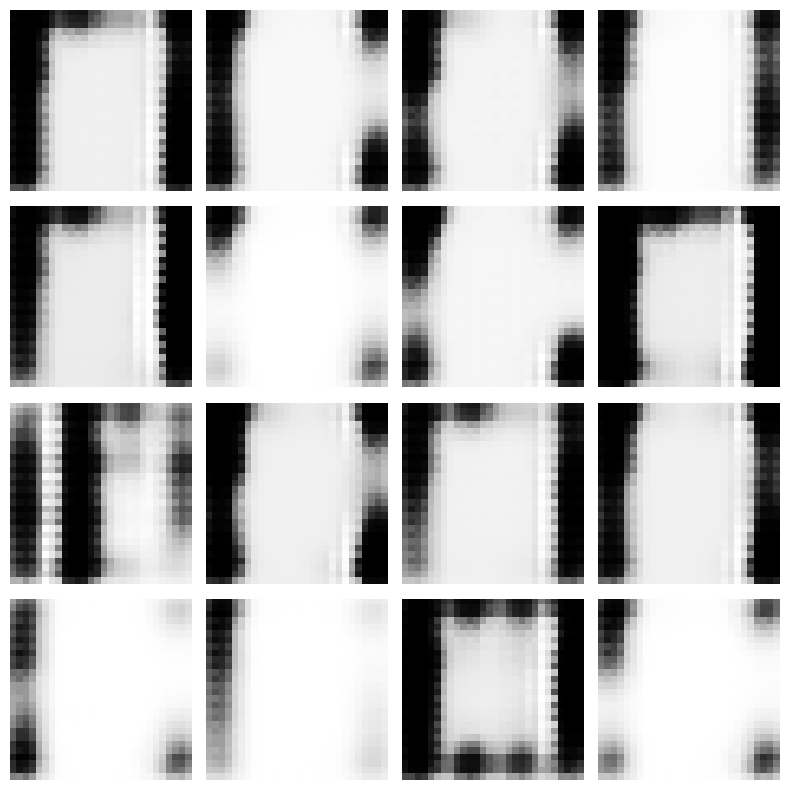

In [14]:
# Plot the images
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(fake[i][0], cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()